In [1]:
import sys
import os

current_dir = os.path.abspath(os.path.dirname('__file__')) 

project_root = os.path.join(current_dir, '../..')

if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
from training.model import FusedFeatureModel
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

/home/zzzdream/code/PW_Bachelor/server/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zzzdream/code/PW_Bachelor/server/venv/lib/python3.12/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


In [10]:
# def visualize_single_feature_map(feature_tensor, original_image_shape, title):
#     """Generic function to plot a 4D feature map (from SegFormer or DPT) as a heatmap."""
#     # Squeeze batch dimension, average across channels (C)
#     # Shape: (1, C, H_map, W_map) -> (H_map, W_map)
#     feature_map = feature_tensor.squeeze(0).mean(dim=0)
    
#     # Normalize to [0, 1]
#     feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
    
#     # Upsample the map to the original image size
#     H, W, _ = original_image_shape.shape
#     heatmap = F.interpolate(
#         feature_map.unsqueeze(0).unsqueeze(0), # (1, 1, H_map, W_map)
#         size=(H, W), 
#         mode='bilinear', 
#         align_corners=False
#     ).squeeze().cpu().numpy()

#     plt.title(title)
#     plt.imshow(original_image_shape)
#     plt.imshow(heatmap, cmap='jet', alpha=0.5)
#     plt.axis('off')
    
def visualize_single_feature_map(feature_tensor_list, original_image_shape, title):
    """
    FIXED: Now takes a list of feature tensors (hidden states) and averages them 
    after upsampling to capture features from all stages.
    """
    
    H, W, _ = original_image_shape.shape
    total_heatmap = torch.zeros((H, W), device=feature_tensor_list[0].device)
    
    # 1. Iterate through all feature map stages
    for feature_tensor in feature_tensor_list:
        # Squeeze batch dimension, average across channels (C)
        # Shape: (1, C, H_map, W_map) -> (H_map, W_map)
        feature_map = feature_tensor.squeeze(0).mean(dim=0).float()
        
        # Upsample the map to the original image size
        upsampled_map = F.interpolate(
            feature_map.unsqueeze(0).unsqueeze(0), # (1, 1, H_map, W_map)
            size=(H, W), 
            mode='bilinear', 
            align_corners=False
        ).squeeze() # Shape: (H, W)
        
        # Accumulate the upsampled maps
        total_heatmap += upsampled_map
        
    # 2. Final averaging and normalization
    heatmap = (total_heatmap / len(feature_tensor_list)).cpu().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    # 3. Plotting
    plt.title(title)
    plt.imshow(original_image_shape)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    

def visualize_dpt_feature_map(dpt_feature_tensor, original_image_shape, title="DPT: Structural Feature Map"):
    """
    Creates a feature map visualization for the DPT encoder output by 
    reshaping the token sequence back into a spatial grid and upsampling.

    Args:
        dpt_feature_tensor (torch.Tensor): The final hidden state from DPT 
                                           (Expected shape: [1, N, C]).
        original_image_shape (tuple): The original image shape (H, W, C), e.g., (1080, 1920, 3).
        title (str): Plot title.
    """
    
    # 1. Squeeze batch dimension: (1, N, C) -> (N, C)
    feature_map_tokens = dpt_feature_tensor.squeeze(0).float()
    
    # Check dimensions for errors
    if feature_map_tokens.dim() != 2:
        print(f"Error: DPT tensor must be 2D after squeezing (N, C). Got {feature_map_tokens.shape}")
        return

    # 2. Separate CLS token and spatial tokens (Assuming CLS is the first token)
    # Spatial Tokens: (N_spatial, C)
    token_scores_spatial = feature_map_tokens[1:]
    
    # 3. Average across channels (C) to get a 1D vector of importance per token: (N_spatial,)
    token_scores = token_scores_spatial.mean(dim=1)

    # --- KEY FIX: RESHAPING THE TOKEN SEQUENCE ---
    N_spatial = token_scores.size(0)
    
    # Calculate the side length of the square patch grid (e.g., 24 for 576 tokens)
    H_map = W_map = int(torch.sqrt(torch.tensor(N_spatial).float()))
    
    if H_map * W_map != N_spatial:
        print(f"Error: Token count {N_spatial} is not a perfect square (e.g., 576, 1024). Cannot reshape to a grid.")
        return

    # Reshape the 1D scores into a 2D map: (N_spatial,) -> (H_map, W_map)
    feature_map_2D = token_scores.reshape(H_map, W_map) 
    
    # 4. Normalize to [0, 1]
    feature_map_2D = (feature_map_2D - feature_map_2D.min()) / (feature_map_2D.max() - feature_map_2D.min())
    
    # 5. Upsample the map to the original image size
    H, W, _ = original_image_shape.shape
    
    # Need to unsqueeze to (1, 1, H_map, W_map) for interpolate
    heatmap = F.interpolate(
        feature_map_2D.unsqueeze(0).unsqueeze(0).cpu(), 
        size=(H, W), 
        mode='bilinear', 
        align_corners=False
    ).squeeze().numpy()

    # --- Plotting (for integration into your visualization script) ---
    plt.title(title)
    
    # Assuming the original image (NumPy array) is passed correctly:
    # (The plot function expects the NumPy image to be loaded outside this utility)
    plt.imshow(original_image_shape) 
    plt.imshow(heatmap, cmap='jet', alpha=0.6)
    plt.axis('off')


def visualize_clip_attention(attentions, original_image_shape):
    """
    FIXED: Calculates the CLS token attention averaged across a range of deep layers 
    to get a more stable and representative focus map.
    """
    
    # 1. Define the layers to average (e.g., the last 5 layers: indices -5 to -1)
    # CLIP ViT-B/32 has 12 layers (indices 0 to 11).
    start_layer_index = max(0, len(attentions) - 5) 
    
    # Initialize a tensor to accumulate the patch attention scores
    H_img, W_img, _ = original_image_shape.shape
    accumulated_heatmap = None

    # 2. Iterate and accumulate CLS attention from selected layers
    for i in range(start_layer_index, len(attentions)):
        attention_layer = attentions[i].squeeze(0) # (Num_Heads, N, N)

        # Average attention across all heads: (Num_Heads, N, N) -> (N, N)
        attention_matrix = attention_layer.mean(dim=0)

        # Get attention from CLS token (index 0) to all patches (index 1 to N-1)
        cls_attention_to_patches = attention_matrix[0, 1:] # Shape: (Num_Patches,)
        
        # Reshape to a square grid
        num_patches = cls_attention_to_patches.size(0)
        grid_size = int(np.sqrt(num_patches))
        
        if grid_size * grid_size != num_patches:
            print(f"Warning: Unexpected patch count {num_patches}. Skipping layer {i}.")
            continue

        attention_grid = cls_attention_to_patches.reshape(grid_size, grid_size).float()
        
        # Upsample the grid to the original image size
        # Needs to be (1, 1, H_map, W_map) for interpolate
        upsampled_heatmap = F.interpolate(
            attention_grid.unsqueeze(0).unsqueeze(0).cpu(),
            size=(H_img, W_img), 
            mode='bilinear', 
            align_corners=False
        ).squeeze()

        if accumulated_heatmap is None:
            accumulated_heatmap = upsampled_heatmap
        else:
            accumulated_heatmap += upsampled_heatmap

    if accumulated_heatmap is None:
        return

    # 3. Normalize the final averaged heatmap
    # Normalize by the number of layers used (len(attentions) - start_layer_index)
    heatmap = (accumulated_heatmap / (len(attentions) - start_layer_index)).numpy()
    
    # Final Min-Max normalization
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # 4. Plotting
    plt.title(f"CLIP: CLS Token Attention (Averaged Layers {start_layer_index+1} to 12)")
    plt.imshow(original_image_shape)
    plt.imshow(heatmap, cmap='jet', alpha=0.6)
    plt.axis('off')


def plot_all_visualizations(model, image_path):
    """Main function to run the model and plot all features."""
    try:
        outputs = model.get_visualization_outputs(image_path)
    except Exception as e:
        print(f"Error during model inference/loading: {e}")
        print("Ensure you have all required Hugging Face models and libraries installed.")
        return

    original_image = outputs['original_image']

    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle("Building Feature Visualizations", fontsize=16)

    # 1. Original Image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # # 2. CLIP Visualization
    plt.sca(axes[1])
    visualize_clip_attention(outputs['clip_attentions'], original_image)
    # visualize_dpt_feature_map(outputs['clip_attentions'], original_image, "CLIP: CLS Token Attention")
    
    # 3. SegFormer Visualization
    plt.sca(axes[2])
    visualize_single_feature_map(outputs['segformer_features'], original_image, "SegFormer: Semantic Features")

    # 4. DPT Visualization
    plt.sca(axes[3])
    visualize_dpt_feature_map(outputs['dpt_features'], original_image, "DPT: Depth/Structural Features")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Some weights of DPTModel were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


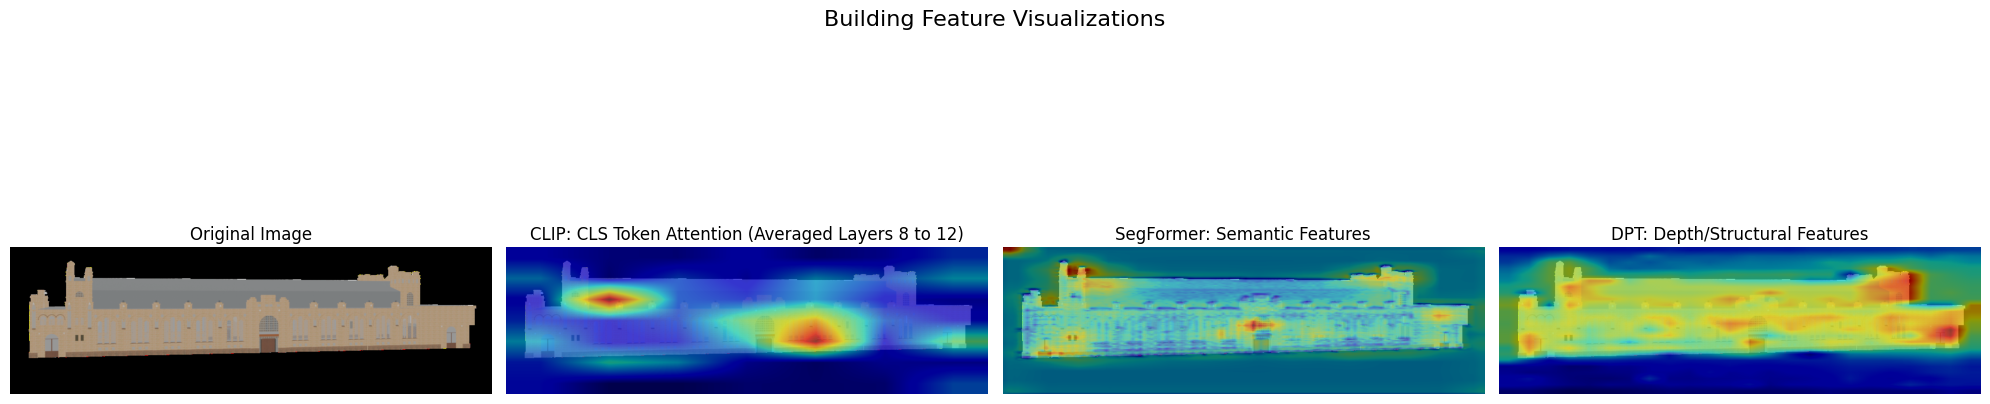

In [14]:
# IMAGE_PATH = "/mnt/c/Users/KMult/Desktop/Praca_inzynierska/models/test_data/render_close_FlatColor_Phone_LowAngle_z-0.1_dir1.png" 
IMAGE_PATH = "/mnt/c/Users/KMult/Desktop/Praca_inzynierska/models/BlenderRenders3/hale_mirowskie/test.png"


fusion_model = FusedFeatureModel()

plot_all_visualizations(fusion_model, IMAGE_PATH)